## Fine Tuning of VGG16 for Biofuel Material Cassification

In [1]:
import lib
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras as kr
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
import itertools

%matplotlib inline

[23:05:10] Library functions loaded.


In [2]:
# Implementation Dependant Globals
REQUIRED_DIMENSIONS = (224, 224)
TRAIN_BATCH_SIZE = 10
VALIDATION_BATCH_SIZE = 10
TEST_BATCH_SIZE = 70

# Import dataset
%run DataPreparation.ipynb 

[23:05:11] Data preparation started.
[23:05:11] Loaded custom functions.
(SKIPPED) Found a non image file:  ./dataset/validation/non_biomass/metal282 - Shortcut.lnk
[Non Processed Classifier Input Data]
Raw pixels matrix: 135.83MB
Raw features matrix: 1.85MB
[23:05:21] Loaded raw congregates of images, features and labels.
[Non Augmented Generators]
Found 248 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
[Augmented Generators]
Found 248 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
[23:05:21] Loaded all generators.
[Total Info]
Number of images: 924
Size of images: 0.01MB
[23:05:21] Data preperation completed!
Time taken: 10.548395156860352 seconds.


#### Fetch & Download VGG16 model

In [3]:
vgg16 = kr.applications.vgg16
vgg16_model = vgg16.VGG16(
    include_top=False, 
    weights='imagenet', 
    input_tensor=kr.layers.Input(shape=REQUIRED_DIMENSIONS+(3,))
)
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Building & Compiling

In [4]:
# Ease of Access
Model, Dropout, Flatten, Dense = kr.models.Model, kr.layers.Dropout, kr.layers.Flatten, kr.layers.Dense

# Construct the Head Model
head_model = vgg16_model.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(512, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

# Place the head model on top of the base model (this will become the actual model we will train)
model = Model(inputs=vgg16_model.input, outputs=head_model)

# Freeze all the layers
for layer in vgg16_model.layers[:]:
    layer.trainable = False

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Warmup Training

In [5]:
# Compile Module
model.compile(
    loss='binary_crossentropy',
    optimizer=kr.optimizers.RMSprop(lr=1e-4),
    metrics=['accuracy']
)

# Train the head of the module (Our Layers)
warmup_history = model.fit_generator(
    train_set,
    steps_per_epoch=train_set.samples/train_set.batch_size,
    epochs=30,
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1,
    shuffle=True
)

warmup_history.plot_title = "Warmup"

Epoch 1/30
50/49 [==============================] - 32s 640ms/step - loss: 4.9877 - accuracy: 0.6633 - val_loss: 2.4396 - val_accuracy: 0.8063
Epoch 2/30
50/49 [==============================] - 25s 505ms/step - loss: 1.5981 - accuracy: 0.8548 - val_loss: 1.4040 - val_accuracy: 0.8662
Epoch 3/30
50/49 [==============================] - 25s 507ms/step - loss: 1.0178 - accuracy: 0.9133 - val_loss: 0.8538 - val_accuracy: 0.9155
Epoch 4/30
50/49 [==============================] - 26s 513ms/step - loss: 0.6668 - accuracy: 0.9456 - val_loss: 1.0241 - val_accuracy: 0.9014
Epoch 5/30
50/49 [==============================] - 26s 517ms/step - loss: 0.7108 - accuracy: 0.9375 - val_loss: 1.1859 - val_accuracy: 0.8908
Epoch 6/30
50/49 [==============================] - 26s 518ms/step - loss: 0.3180 - accuracy: 0.9677 - val_loss: 0.7709 - val_accuracy: 0.9190
Epoch 7/30
50/49 [==============================] - 26s 523ms/step - loss: 0.3241 - accuracy: 0.9758 - val_loss: 0.7514 - val_accuracy: 0.9296

2/2 [==============================] - 6s 3s/step
              precision    recall  f1-score   support

     biomass       0.92      0.94      0.93        70
 non_biomass       0.94      0.91      0.93        70

    accuracy                           0.93       140
   macro avg       0.93      0.93      0.93       140
weighted avg       0.93      0.93      0.93       140

Normalized confusion matrix


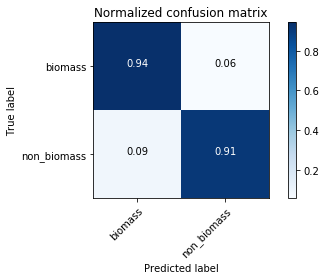

In [6]:
# Make predictions
predictions = model.predict_generator(test_set, steps=test_set.samples/test_set.batch_size, verbose=1)
normalised_predictions = np.argmax(predictions, axis=1)

# Print out scikit report
print(classification_report(test_set.classes, normalised_predictions, target_names=CLASSES))

# Draw confusion matrix
lib.plot_confusion_matrix(test_set.classes, normalised_predictions, CLASSES)

#### Final Training

In [7]:
# Reset validaiton & train set generators
train_set.reset()
validation_set.reset()

# Now that the head FC layers have been trained/initialized, lets
# Unfreeze the final set of CONV layers and make them trainable
for layer in vgg16_model.layers[15:]:
	layer.trainable = True

    
# Recompile module for changes to take effect, now using SGD with very small learning rate
model.compile(
    loss="binary_crossentropy", 
    optimizer=kr.optimizers.RMSprop(lr=1e-4), 
    metrics=["accuracy"]
)    

# Train the whole module
final_history = model.fit_generator(
    train_set,
    steps_per_epoch=train_set.samples/train_set.batch_size,
    epochs=30,
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1,
    shuffle=True
)

final_history.plot_title = "Final"

Epoch 1/30
50/49 [==============================] - 27s 532ms/step - loss: 3.5958 - accuracy: 0.7581 - val_loss: 2.8191 - val_accuracy: 0.8063
Epoch 2/30
50/49 [==============================] - 27s 531ms/step - loss: 3.8571 - accuracy: 0.7379 - val_loss: 1.7000 - val_accuracy: 0.8838
Epoch 3/30
50/49 [==============================] - 26s 526ms/step - loss: 1.8641 - accuracy: 0.8710 - val_loss: 2.0032 - val_accuracy: 0.8556
Epoch 4/30
50/49 [==============================] - 26s 526ms/step - loss: 1.3863 - accuracy: 0.9032 - val_loss: 0.6183 - val_accuracy: 0.9507
Epoch 5/30
50/49 [==============================] - 27s 533ms/step - loss: 1.0231 - accuracy: 0.9173 - val_loss: 0.8141 - val_accuracy: 0.9190
Epoch 6/30
50/49 [==============================] - 26s 529ms/step - loss: 0.7599 - accuracy: 0.9415 - val_loss: 1.3941 - val_accuracy: 0.8627
Epoch 7/30
50/49 [==============================] - 27s 534ms/step - loss: 0.9842 - accuracy: 0.9093 - val_loss: 0.7319 - val_accuracy: 0.9049

2/2 [==============================] - 3s 2s/step
              precision    recall  f1-score   support

     biomass       0.84      1.00      0.92        70
 non_biomass       1.00      0.81      0.90        70

    accuracy                           0.91       140
   macro avg       0.92      0.91      0.91       140
weighted avg       0.92      0.91      0.91       140

Normalized confusion matrix


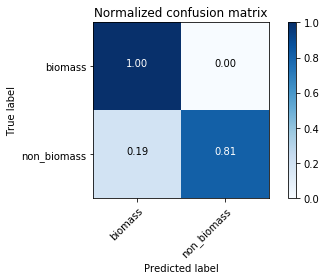

In [8]:
# Reset from previous predictions
test_set.reset()

# Make new predictions
predictions = model.predict_generator(test_set, steps=test_set.samples/test_set.batch_size, verbose=1)
normalised_predictions = np.argmax(predictions, axis=1)

# Print out scikit report
print(classification_report(test_set.classes, normalised_predictions, target_names=CLASSES))

# Draw confusion matrix
lib.plot_confusion_matrix(test_set.classes, normalised_predictions, CLASSES)

#### Visualising Training History

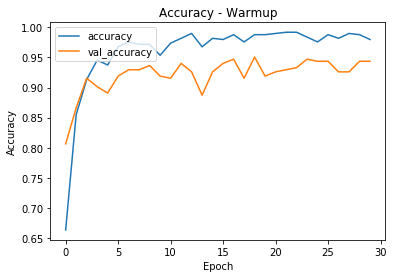

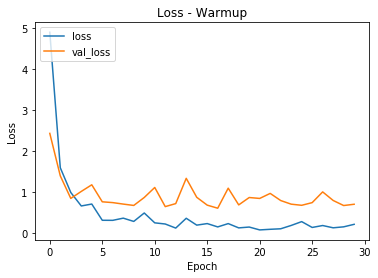

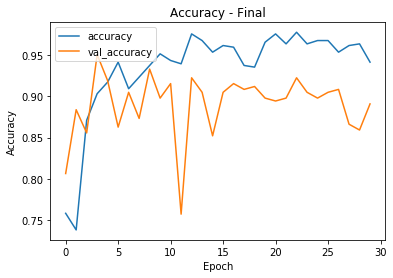

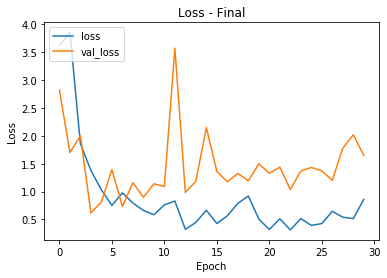

In [9]:
global_history = [warmup_history, final_history]

for history in global_history:
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title("Accuracy - " + history.plot_title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss - " + history.plot_title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [10]:
model.save('app\\trained_models\\VGG16')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: app\trained_models\VGG16\assets
